In [9]:
import pandas as pd 
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [10]:
folder = "/media/riannek/minimax/gleis/speed_run24-o3d"
df = pd.read_csv(os.path.join(folder, 'speedlog.csv'))
df['file'] = df['file'].fillna("")
df['file'] = df['file'].apply(lambda x: os.path.basename(x))
df['what'] = df['what'].replace({'voxelfilter': 'Voxelfilter', 'Growing lines': 'Linienbildung', 'Central points': 'Gleiserkennung', 'read': 'Lesen'})
df.head()


,what,file,time,points
0,Lesen,4481275_5357000.copc.laz,0.755605,1746830
1,Lesen,4475525_5341275.copc.laz,0.982993,1298026
2,Voxelfilter,4475525_5341275.copc.laz,4.438115,145607
3,Lesen,4475625_5341350.copc.laz,0.260133,268017
4,Voxelfilter,4475625_5341350.copc.laz,1.097492,28071


Voxelfilter ist hier ohne read:

In [11]:
grouped = df.groupby('what')['time'].sum()  / 60
grouped  

what
Gleiserkennung        263.483666
Lesen                 115.740162
Linienbildung          39.683240
Points with margin      0.000000
Seed points             0.000000
Voxelfilter           388.460187
Name: time, dtype: float64

In [12]:
grouped['Voxelfilter'] = grouped['Voxelfilter'] + grouped['Lesen'] 
read = grouped['Lesen']
grouped = grouped.drop('Lesen')
grouped = grouped[grouped > 0]

In [13]:
grouped  

what
Gleiserkennung    263.483666
Linienbildung      39.683240
Voxelfilter       504.200349
Name: time, dtype: float64

In [14]:
grouped * 100 / grouped.sum()

what
Gleiserkennung    32.634921
Linienbildung      4.915141
Voxelfilter       62.449938
Name: time, dtype: float64

In [15]:
read * 100 / grouped.sum()

np.float64(14.335503590338636)

In [16]:
read * 100 / grouped['Voxelfilter']

np.float64(22.955192722008526)

In [17]:
grouped.sum() // 60, grouped.sum() % 60

(np.float64(13.0), np.float64(27.36725469827661))

In [18]:
custom_order = ['Voxelfilter', 'Gleiserkennung' ,'Linienbildung']
grouped = grouped.loc[custom_order]

(np.float64(-1.09999940771285),
 np.float64(1.0999976691549893),
 np.float64(-1.09999839026941),
 np.float64(1.0999999233461624))

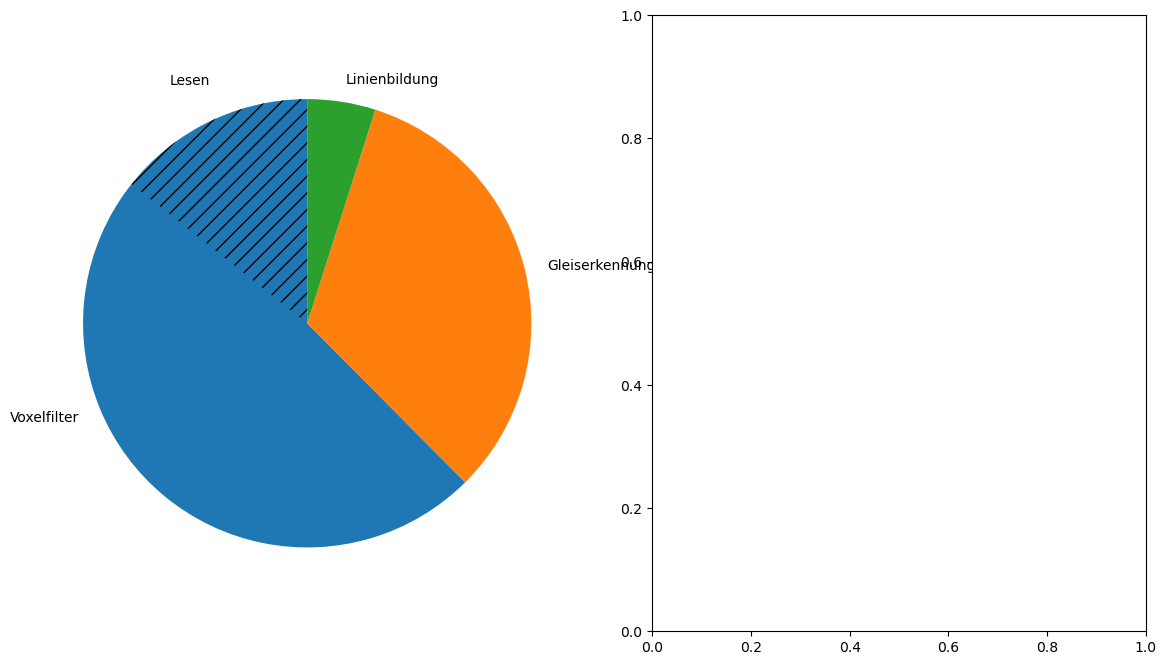

In [19]:

# Prepare data
labels = grouped.index
sizes = grouped.values

# Pie chart
fig, ax = plt.subplots(1,2, figsize=(14, 8))
wedges, texts = ax[0].pie(sizes, labels=labels, startangle=90)

# Find index of the combined category
combined_index = list(labels).index('Voxelfilter')

# Overlay the "hatched" part (e.g., 'bar') manually
# Calculate angle for the segment
angle = 360 * read / grouped.sum()

# Determine where the wedge starts
startangle = 90  # if same as above
angle_offset = sum(sizes[:combined_index]) / sizes.sum() * 360

# Draw a hatched wedge manually
from matplotlib.patches import Wedge

theta1=startangle + angle_offset
theta2=theta1 + angle
theta_mid = (theta1 + theta2) / 2

hatch_wedge = Wedge(center=(0, 0),
                    r=1, #0.95,  # slightly smaller
                    theta1=theta1,
                    theta2=theta2,
                    facecolor='none',
                    hatch='//',
                    edgecolor='black',
                    linewidth=0)

ax[0].add_patch(hatch_wedge)

# Convert polar to cartesian for label position
r = 1.2  # radius slightly outside the wedge
x = r * np.cos(np.deg2rad(theta_mid))
y = r * np.sin(np.deg2rad(theta_mid))

# Add the label manually
ax[0].text(x, y, 'Lesen', ha='center', va='center')

ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.



In [20]:
linelayer = gpd.read_file(os.path.join(folder, 'temp.gpkg'), layer='centerlines')
linelayer.head()

,used,geometry
0,0,"LINESTRING Z (4476157.809 5342334.019 485.047,..."
1,0,"LINESTRING Z (4476157.809 5342334.019 485.047,..."
2,1,"LINESTRING Z (4474825.226 5340468.253 503.113,..."
3,1,"LINESTRING Z (4476144.902 5342268.597 485.371,..."
4,1,"LINESTRING Z (4476474.479 5343841.752 486.475,..."


In [21]:
linelayer['num_points'] = linelayer.geometry.apply(lambda geom: len(geom.coords))
linelayer.head()

,used,geometry,num_points
0,0,"LINESTRING Z (4476157.809 5342334.019 485.047,...",2680
1,0,"LINESTRING Z (4476157.809 5342334.019 485.047,...",825
2,1,"LINESTRING Z (4474825.226 5340468.253 503.113,...",2594
3,1,"LINESTRING Z (4476144.902 5342268.597 485.371,...",1851
4,1,"LINESTRING Z (4476474.479 5343841.752 486.475,...",239


In [22]:
linelayer['num_points'].describe()

count      152.000000
mean       507.111842
std       1290.643453
min          9.000000
25%         44.000000
50%        110.000000
75%        349.500000
max      10764.000000
Name: num_points, dtype: float64

In [23]:
linepointsum = linelayer['num_points'].sum()
linepointsum  

np.int64(77081)

In [24]:
df['what2'] = df['what'].replace({'Lesen': 'Punktwolke', 'Seed points': 'Saatpunkte', 'GrowingLines': 'Stützpunkte', 'Gleiserkennung': 'Punkte Gleismitte'})
punktzahl = df.groupby('what2')['points'].sum()
punktzahl 

what2
Linienbildung                   0
Points with margin      794790330
Punkte Gleismitte         1039111
Punktwolke            13891956830
Saatpunkte                2096281
Voxelfilter             749670703
Name: points, dtype: int64

In [25]:
print(punktzahl.to_latex())

\begin{tabular}{lr}
\toprule
 & points \\
what2 &  \\
\midrule
Linienbildung & 0 \\
Points with margin & 794790330 \\
Punkte Gleismitte & 1039111 \\
Punktwolke & 13891956830 \\
Saatpunkte & 2096281 \\
Voxelfilter & 749670703 \\
\bottomrule
\end{tabular}



In [26]:
punktzahl['Stützpunkte'] = linepointsum
punktzahl.drop('Points with margin', inplace=True)

custom_order = ['Punktwolke', 'Voxelfilter', 'Saatpunkte', 'Punkte Gleismitte', 'Stützpunkte']
punktzahl = punktzahl.loc[custom_order] 
punktzahl 

what2
Punktwolke           13891956830
Voxelfilter            749670703
Saatpunkte               2096281
Punkte Gleismitte        1039111
Stützpunkte                77081
Name: points, dtype: int64

In [27]:
punktzahl['Punktwolke'] / punktzahl['Saatpunkte']

np.float64(6626.953557275957)

Text(-0.1, 1.05, 'b)')

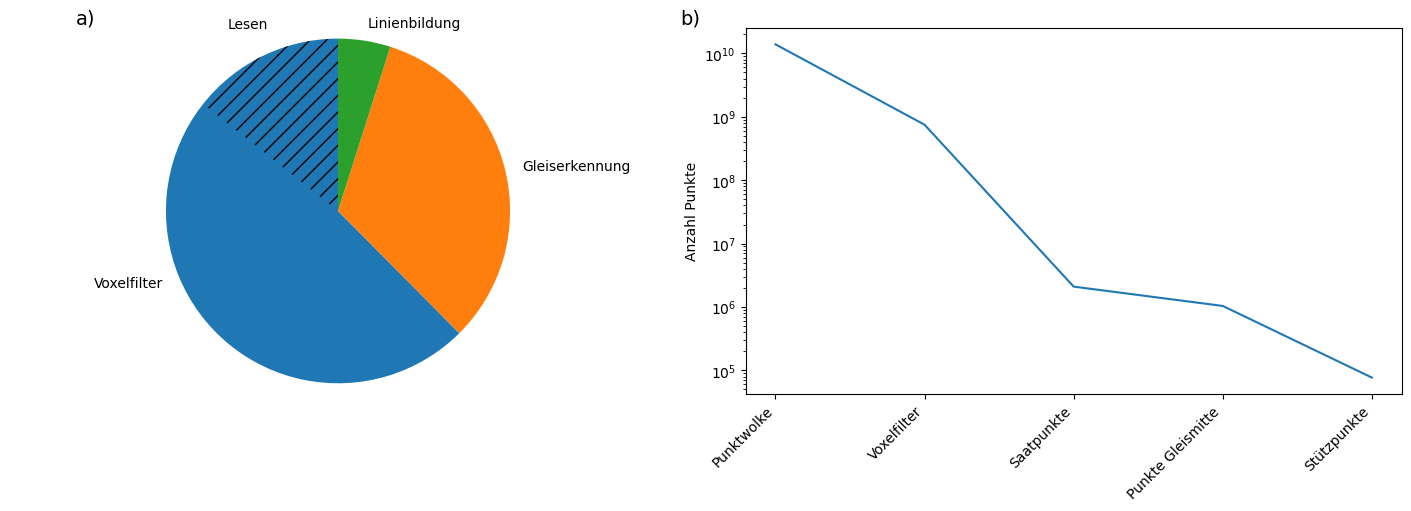

In [28]:

# Prepare data
labels = grouped.index
sizes = grouped.values

# Pie chart
fig, ax = plt.subplots(1,2, figsize=(14, 5), constrained_layout=True)
wedges, texts = ax[0].pie(sizes, labels=labels, startangle=90)

# Find index of the combined category
combined_index = list(labels).index('Voxelfilter')

# Overlay the "hatched" part (e.g., 'bar') manually
# Calculate angle for the segment
angle = 360 * read / grouped.sum()

# Determine where the wedge starts
startangle = 90  # if same as above
angle_offset = sum(sizes[:combined_index]) / sizes.sum() * 360

# Draw a hatched wedge manually
from matplotlib.patches import Wedge

theta1=startangle + angle_offset
theta2=theta1 + angle
theta_mid = (theta1 + theta2) / 2

hatch_wedge = Wedge(center=(0, 0),
                    r=1, #0.95,  # slightly smaller
                    theta1=theta1,
                    theta2=theta2,
                    facecolor='none',
                    hatch='//',
                    edgecolor='black',
                    linewidth=0)

ax[0].add_patch(hatch_wedge)

# Convert polar to cartesian for label position
r = 1.2  # radius slightly outside the wedge
x = r * np.cos(np.deg2rad(theta_mid))
y = r * np.sin(np.deg2rad(theta_mid))

# Add the label manually
ax[0].text(x, y, 'Lesen', ha='center', va='center')

ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax[1].plot(punktzahl.index, punktzahl.values)
ax[1].set_yscale('log')
ax[1].set_ylabel('Anzahl Punkte')
#ax[1].set_xlabel('Bearbeitungsschritt')
# ax[1].tick_params(axis='x', labelrotation=45)
for label in ax[1].get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')  # move anchor to the left of the label
    label.set_verticalalignment('top')      # optional: improves baseline alignment

ax[0].text(0.1, 1.05, 'a)', transform=ax[0].transAxes,
           fontsize=14, va='top', ha='left')

ax[1].text(-0.1, 1.05, 'b)', transform=ax[1].transAxes,
           fontsize=14, va='top', ha='left')

In [29]:
fig.savefig('speed_pie_chart.png', dpi=300, bbox_inches='tight')

In [30]:
30/80

0.375

In [2]:
1/5

0.2